In [1]:
import torch
import torch.nn as nn
import cv2
import numpy as np

import os
import matplotlib.pyplot as plt
import time

from collections.abc import Iterable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import make_grid

In [2]:
class ColorImageDataset(Dataset):

    def __init__(self, path, code=cv2.COLOR_BGR2RGB, transform=transforms.ToTensor()):
        """
        :param path: Path to the image directory location.
        """
        imgs = None
        for folder, sub_folder, filenames in os.walk(path):
            imgs = [cv2.imread(f'{path}/{file}') for file in filenames]
            imgs = [cv2.cvtColor(img, code) for img in imgs]

        self.imgs = imgs
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, subscript):
        if isinstance(subscript, slice):
            imgs = []
            for img in self.imgs[subscript.start:subscript.stop:subscript.step]:
                img = self.transform(img)
                imgs.append(img)
                return imgs
        else:
            return self.transform(self.imgs[subscript])


#### Custom transformation class to resize images with ```OpenCV``` and later this class instance use with other transformation classes with ```transforms.Compose```.

In [3]:
class OpenCVResize(object):

    def __init__(self, size):
        assert isinstance(size, int) or isinstance(size, Iterable) and len(size) == 2
        self.size = size

    def __call__(self, pic):
        return cv2.resize(pic, dsize=self.size)


In [4]:
tf = transforms.Compose({
    OpenCVResize(size=(320, 180)),
    transforms.ToTensor()
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225])
})

gray_dataset = ColorImageDataset(path='../dataset/color', transform=tf, code=cv2.COLOR_BGR2GRAY)
rgb_dataset = ColorImageDataset(path='../dataset/color', transform=tf)

In [5]:
torch.manual_seed(72)

# GRAYSCALE IMAGES USE TO TRAIN NEURAL NETWORKS.
gray_data_loader = DataLoader(dataset=gray_dataset, batch_size=12, shuffle=False)
# COLOR IMAGES JUST FOR VISUALIZATION PURPOSE.
rgb_data_loader = DataLoader(dataset=rgb_dataset, batch_size=12, shuffle=False)

#### View a single batch grayscale and colored image sample.

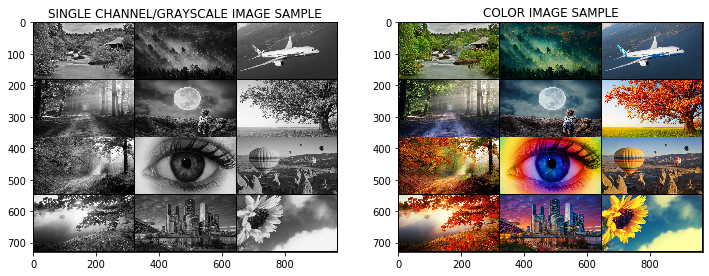

In [6]:
g_ims, rgb_ims = None, None
for g_ims in gray_data_loader:
    break

for rgb_ims in rgb_data_loader:
    break

plt.figure(figsize=(12, 10))

im = make_grid(g_ims, nrow=3, normalize=True)

plt.subplot(121)
plt.imshow(np.transpose(im, axes=(1, 2, 0)))
plt.title("SINGLE CHANNEL/GRAYSCALE IMAGE SAMPLE")

im = make_grid(rgb_ims, nrow=3, normalize=True)

plt.subplot(122)
plt.imshow(np.transpose(im, axes=(1, 2, 0)))
plt.title("COLOR IMAGE SAMPLE")
plt.show()

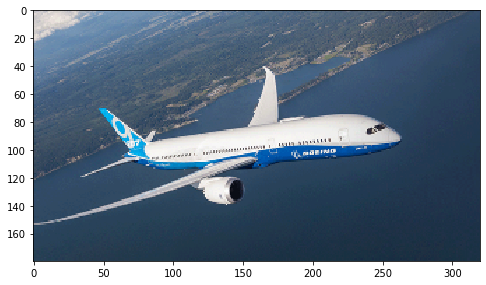

In [7]:
plt.figure(figsize=(8, 7))
plt.imshow(np.transpose(rgb_ims[2], axes=(1, 2, 0)))

####  Convolutional Neural Network Model

In [8]:
class RGBNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.sequence = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=20, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            # nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(in_channels=20, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=18, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(18),
            nn.ReLU(),
            nn.Conv2d(in_channels=18, out_channels=3, kernel_size=3, stride=1, padding=1),
            # nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, X):
        return self.sequence(X)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


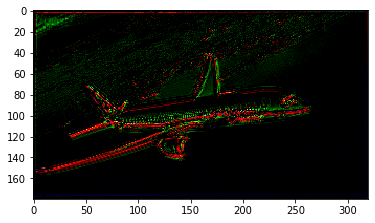

In [9]:
model = RGBNet()

s = model(g_ims[2].view(-1, 1, 180, 320))
plt.imshow(np.transpose(s.detach().view(-1, 180, 320), axes=(1, 2, 0)))

#### Training Neural Network Models


In [10]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [11]:
epoch = 3
losses = []

start = time.time()

for i in range(epoch):
    i += 1

    # TRAIN RED MODEL.
    for batch, (X, y) in enumerate(zip(gray_data_loader, rgb_data_loader)):
        batch += 1

        y_pred = model(X)
        loss = criterion(y_pred, y)

        losses.append(loss)

        print(f'Epoch: {i}, Batch: {batch} -> Loss: {loss}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

duration = time.time() - start
print(f'Duration to total execution: {duration / 60:.2f} minutes')

Epoch: 1, Batch: 1 -> Loss: 0.7106131911277771
Epoch: 1, Batch: 2 -> Loss: 0.19332842528820038
Epoch: 1, Batch: 3 -> Loss: 0.43392470479011536
Epoch: 1, Batch: 4 -> Loss: 0.20692038536071777
Epoch: 1, Batch: 5 -> Loss: 0.14096680283546448
Epoch: 1, Batch: 6 -> Loss: 0.06657395511865616
Epoch: 1, Batch: 7 -> Loss: 0.08474000543355942
Epoch: 1, Batch: 8 -> Loss: 0.07333873212337494
Epoch: 1, Batch: 9 -> Loss: 0.08804129809141159
Epoch: 1, Batch: 10 -> Loss: 0.0680016577243805
Epoch: 1, Batch: 11 -> Loss: 0.08432386815547943
Epoch: 1, Batch: 12 -> Loss: 0.036184247583150864
Epoch: 1, Batch: 13 -> Loss: 0.03235475718975067
Epoch: 1, Batch: 14 -> Loss: 0.03150783106684685
Epoch: 1, Batch: 15 -> Loss: 0.039318133145570755
Epoch: 1, Batch: 16 -> Loss: 0.06326872855424881
Epoch: 1, Batch: 17 -> Loss: 0.062078021466732025
Epoch: 1, Batch: 18 -> Loss: 0.04440426826477051
Epoch: 1, Batch: 19 -> Loss: 0.04198000580072403
Epoch: 1, Batch: 20 -> Loss: 0.04294806346297264
Epoch: 2, Batch: 1 -> Loss: 

Text(0, 0.5, 'Loss')

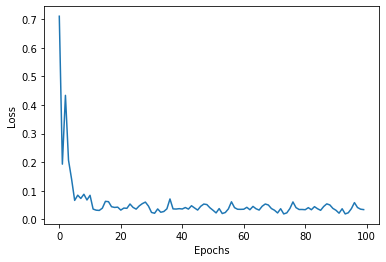

In [12]:
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')

#### Validate images with same dataset used to train.

In [13]:
@torch.no_grad()
def validate(img):

    model.eval()

    rgb = model(img)

    print(rgb.shape)

    plt.imshow(np.transpose(rgb.view(-1, 180, 320), axes=(1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 180, 320])


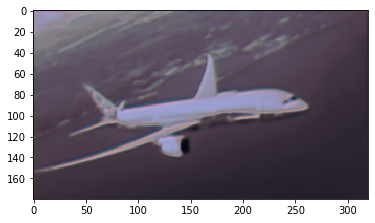

In [20]:
validate(g_ims[2].view(-1, 1, 180, 320))